In [1]:
from sklearn.ensemble import RandomForestClassifier

from utils.loader import FactoryLoader
from utils.ml import MLPipeline
from utils.preprocessing import PreprocessingFactory
from utils.feature_extraction import *
from utils.utils import *

In [2]:
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"
TRAIN_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\train"

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import logging
import pandas as pd
from sklearn.base import ClassifierMixin

from utils.feature_extraction import FeatureExtractionStrategy
from utils.preprocessing import PreprocessingFactory

# Set up logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class MLPipeline:
    def __init__(self, dataset_path, preprocessing_factory: PreprocessingFactory,
                 feature_strategy: FeatureExtractionStrategy,
                 classifiers: list[ClassifierMixin], percentage: int = 100,
                 verbose: bool = False, shuffle=False):
        self.loader = FactoryLoader(path=dataset_path, factory=preprocessing_factory, percentage=percentage,
                                    shuffle=shuffle)
        self.feature_strategy = feature_strategy
        self.classifiers = classifiers
        self.feature_matrix = None
        self.labels = None
        self.is_extracted = False
        self.fitted_classifiers = {}
        self.predictions = {}
        self.verbose = verbose  # Control logging verbosity

        if self.verbose:
            logger.info("MLPipeline initialized with dataset path: %s", dataset_path)
            logger.info("Preprocessing steps", self.loader.get_transformation_steps())

    def run_feature_extraction(self):
        """Extracts features and labels from the dataset."""
        if self.verbose:
            logger.info("Running feature extraction...")

        loader_data = self.loader.get_loader()  # This returns the dataset loader
        self.feature_matrix, self.labels = self.feature_strategy.run(loader_data)
        self.is_extracted = True

        if self.verbose:
            logger.info("Feature extraction completed. Extracted %d features.", len(self.feature_matrix))

    def fit_classifiers(self):
        """
        Fits all classifiers on the extracted features using the labels obtained from the loader.
        """
        if not self.is_extracted:
            raise RuntimeError("Features must be extracted before fitting classifiers.")

        if self.verbose:
            logger.info("Fitting classifiers...")

        self.fitted_classifiers = {}
        for clf in self.classifiers:
            clf.fit(self.feature_matrix, self.labels)
            self.fitted_classifiers[clf.__class__.__name__] = clf
            if self.verbose:
                logger.info("Fitted classifier: %s", clf.__class__.__name__)

        if self.verbose:
            logger.info("All classifiers have been fitted.")

    def predict_with_classifiers(self, new_dataset_path, percentage=100):
        """
        Predicts the output for a new dataset using all fitted classifiers and stores the results.

        Args:
        new_dataset_path: The path to the new dataset for prediction.

        Returns:
        A dictionary containing the predictions from all classifiers.
        """
        if not self.fitted_classifiers:
            raise RuntimeError("Classifiers must be fitted before making predictions.")

        if self.verbose:
            logger.info("Predicting with classifiers on dataset: %s", new_dataset_path)

        # Load and extract features from the new dataset
        new_loader = FactoryLoader(path=new_dataset_path, factory=self.loader.get_factory(), percentage=percentage)
        new_feature_matrix, new_labels = self.feature_strategy.run(new_loader.get_loader())

        # Store predictions in the class attribute
        self.predictions = {"GT": new_labels,}
        for clf_name, clf in self.fitted_classifiers.items():
            
            self.predictions[clf_name] = clf.predict(new_feature_matrix)
            if self.verbose:
                logger.info("Predictions made with classifier: %s", clf_name)

        return self.predictions

    def calculate_metrics(self, metrics=['accuracy', 'precision', 'recall', 'f1']):
        """
        Calculates specified metrics for each classifier's stored predictions.

        Args:
        true_labels (array-like): Array of true labels for comparison.
        metrics (list of str): List of metrics to calculate; options are 'accuracy', 'precision', 'recall', 'f1'.

        Returns:
        dict: A dictionary with classifier names as keys and calculated metrics as values.

        Raises:
        RuntimeError: If predictions are not available.
        """
        if not self.predictions:
            raise RuntimeError("No predictions available. Run 'predict_with_classifiers' first.")

        results = {}
        for clf_name, clf_predictions in self.predictions.items():
            clf_metrics = {}
            if 'accuracy' in metrics:
                clf_metrics['accuracy'] = accuracy_score(self.predictions["GT"], clf_predictions)
            if 'precision' in metrics:
                clf_metrics['precision'] = precision_score(self.predictions["GT"], clf_predictions, average='weighted')
            if 'recall' in metrics:
                clf_metrics['recall'] = recall_score(self.predictions["GT"], clf_predictions, average='weighted')
            if 'f1' in metrics:
                clf_metrics['f1'] = f1_score(self.predictions["GT"], clf_predictions, average='weighted')
            
            results[clf_name] = clf_metrics
            
            if self.verbose:
                logger.info("Metrics for classifier %s: %s", clf_name, clf_metrics)
        
        return results

    def get_feature_names(self):
        """Returns feature names extracted by the strategy."""
        return self.feature_strategy.get_feature_names()

    def get_classes(self):
        """Returns classes found in training."""
        return self.loader.get_classes()

    def save_feature_matrix_to_excel(self, output_dir: str = './'):
        """
        Saves the feature matrix to an Excel file using preprocessing step names in the filename.

        Args:
        output_dir (str): Directory where the Excel file will be saved. Defaults to the current directory.

        Returns:
        str: The path to the saved Excel file.
        """
        if not self.is_extracted:
            raise RuntimeError("Features must be extracted before saving.")

        if self.verbose:
            logger.info("Saving feature matrix to Excel...")

        # Get the step names from the preprocessing factory
        step_names = "_".join(self.loader.get_transformation_steps().keys())
        if not step_names:
            step_names = 'default'

        # Create the file path using the step names
        file_name = f'features_{step_names}.xlsx'
        file_path = output_dir + file_name

        # Convert the feature matrix to a pandas DataFrame
        feature_df = pd.DataFrame(self.feature_matrix, columns=self.get_feature_names())

        # Save to Excel
        feature_df.to_excel(file_path, index=False)

        if self.verbose:
            logger.info("Feature matrix saved to %s", file_path)

        return file_path

In [30]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 


percent = 100

# Initialize the FactoryLoader
factory = PreprocessingFactory()
factory.clahe()
factory.normalize2float()
factory.pad2square(fill=0)
factory.resize((200,200))
factory_loader = FactoryLoader(path=VAL_PATH, batch_size=24, factory=factory, percentage=percent, shuffle=True)

# Create the feature extraction pipeline strategy and add desired features
strategy = FeatureExtractionStrategy()
strategy.add_extractor(MeanExtractor())  # Add mean feature
strategy.add_extractor(StdExtractor())   # Add standard deviation feature
strategy.add_extractor(VarExtractor())   # Add variance feature
strategy.add_extractor(MaxExtractor())   # Add maximum pixel value feature

# Create classifiers
svm = SVC(C=1., kernel='linear', gamma="scale", probability=False, random_state=42, tol=0.0001)
rf = RandomForestClassifier(n_estimators=12)

pipeline = MLPipeline(dataset_path=TRAIN_PATH, preprocessing_factory=factory, feature_strategy=strategy, classifiers=[svm, rf], percentage=percent, verbose=True, shuffle=True)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Programs\miniconda3\envs\cv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Programs\miniconda3\en

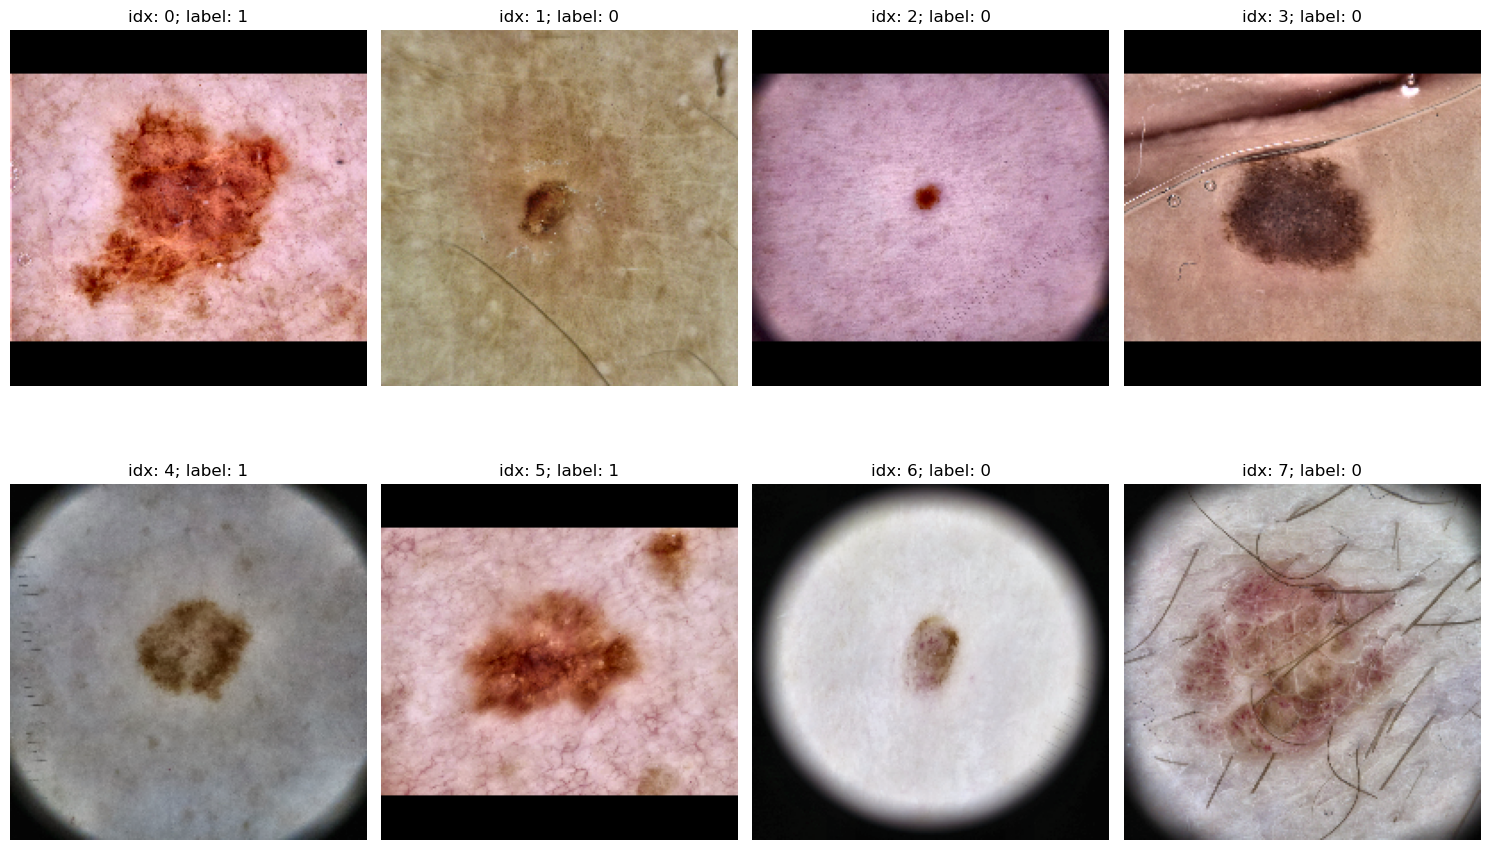

In [41]:
pipeline.loader.show_images()

In [31]:
pipeline.run_feature_extraction()


INFO:__main__:Running feature extraction...
INFO:__main__:Feature extraction completed. Extracted 15195 features.


In [32]:
print("Preprocessing steps")
print(pipeline.loader.get_transformation_steps())
print("\nFeature names")
print(pipeline.get_feature_names())
print("\nSize")

print(pipeline.feature_matrix.shape)

Preprocessing steps
{'clahe': {'clip_limit': 2.0, 'tile_grid_size': (8, 8)}, '01_norm': {}, 'pad2square': {'fill': 0}, 'resize': {'size': (200, 200)}}

Feature names
['mean_channel_0', 'mean_channel_1', 'mean_channel_2', 'std_channel_0', 'std_channel_1', 'std_channel_2', 'var_channel_0', 'var_channel_1', 'var_channel_2', 'max_channel_0', 'max_channel_1', 'max_channel_2']

Size
(15195, 12)


In [33]:
pipeline.fit_classifiers()


INFO:__main__:Fitting classifiers...
INFO:__main__:Fitted classifier: SVC
INFO:__main__:Fitted classifier: RandomForestClassifier
INFO:__main__:All classifiers have been fitted.


In [34]:
pipeline.predict_with_classifiers(VAL_PATH, percent)

INFO:__main__:Predicting with classifiers on dataset: C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val
--- Logging error ---
Traceback (most recent call last):
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Programs\miniconda3\envs\cv\Lib\logging\__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Programs\miniconda3\envs\cv\Lib\site-packag

{'GT': array([0, 0, 0, ..., 0, 1, 0]),
 'SVC': array([0, 0, 0, ..., 0, 1, 0]),
 'RandomForestClassifier': array([0, 0, 0, ..., 0, 0, 0])}

In [35]:
pipeline.predictions

{'GT': array([0, 0, 0, ..., 0, 1, 0]),
 'SVC': array([0, 0, 0, ..., 0, 1, 0]),
 'RandomForestClassifier': array([0, 0, 0, ..., 0, 0, 0])}

In [36]:
pipeline.calculate_metrics()

INFO:__main__:Metrics for classifier GT: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
INFO:__main__:Metrics for classifier SVC: {'accuracy': 0.7062697576396206, 'precision': 0.71264043616031, 'recall': 0.7062697576396206, 'f1': 0.7032497211930407}
INFO:__main__:Metrics for classifier RandomForestClassifier: {'accuracy': 0.7131190727081138, 'precision': 0.7352224143202891, 'recall': 0.7131190727081138, 'f1': 0.7049375365734976}


{'GT': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
 'SVC': {'accuracy': 0.7062697576396206,
  'precision': 0.71264043616031,
  'recall': 0.7062697576396206,
  'f1': 0.7032497211930407},
 'RandomForestClassifier': {'accuracy': 0.7131190727081138,
  'precision': 0.7352224143202891,
  'recall': 0.7131190727081138,
  'f1': 0.7049375365734976}}